<a href="https://www.kaggle.com/code/risakashiwabara/starter-obesity-risk-pytorch?scriptVersionId=162859564" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import RMSprop, Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
df_test_1 = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
display(df_train.head())
display(df_test_1.head())

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


# traindata

In [3]:
binary_cols = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

for col in binary_cols:
    df_train[col] = df_train[col].map({'yes': 1, 'no': 0})
    
df_train[binary_cols].head()

df_train['CAEC'] = df_train['CAEC'].map({
    'no': 0,
    'Always': 3,
    'Frequently': 2,
    'Sometimes': 1
})

df_train['CALC'] = df_train['CALC'].map({
    'no': 0,
    'Frequently': 2,
    'Sometimes': 1
})

transport_mapping = {
    'Bike': 2,
    'Walking': 2,
    'Public_Transportation': 1,
    'Automobile': 0,
    'Motorbike': 0,
}
df_train['MTRANS'] = df_train['MTRANS'].map(transport_mapping)


df_train = pd.get_dummies(df_train, columns=['Gender'], prefix='Is', dtype='int64')
df_train.drop(columns=['Is_Male'], inplace=True)

target_mapping = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

le = LabelEncoder()
df_train['NObeyesdad'] = le.fit_transform(df_train['NObeyesdad'].map(target_mapping))

df_train['BMI'] = df_train['Weight'] / (df_train['Height'] ** 2)

df_train.head()

,id,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,Is_Female,BMI
0,0,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,1,0,2.763573,0,0.000000,0.976473,1,1,3,0,28.259565
1,1,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,2,0,2.000000,0,1.000000,1.000000,0,0,1,1,23.422091
2,2,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,1,0,1.910378,0,0.866045,1.673584,0,1,0,1,17.126706
3,3,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,1,0,1.674061,0,1.467863,0.780199,1,1,6,1,44.855798
4,4,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,1,0,1.979848,0,1.967973,0.931721,1,1,3,0,25.599151


# Torch

In [4]:
N_CLASSES = df_train['NObeyesdad'].nunique()
N_CLASSES

7

In [5]:
torch.manual_seed(13)
np.random.seed(13)

In [6]:
EPOCHS = 400
BATCH_SIZE = 16
LEARNING_RATE = 0.007
NUM_FEATURES = len(df_train.drop(['id', 'NObeyesdad'], axis=1).columns)

In [7]:
X = df_train.drop(['id', 'NObeyesdad'], axis=1).values
y = df_train['NObeyesdad'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
# Converting From Numpy Array To Torch Tensor
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [10]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [11]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=N_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=17, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=7, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [12]:
def train_network(model, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs, train_losses, test_losses):
    print("Begin training.")
    for epoch in range(num_epochs):
    
        optimizer.zero_grad()
        output_train = model(X_train.to(device))
        loss_train = criterion(output_train, y_train.to(device))
        loss_train.backward()
        optimizer.step()

        output_test = model(X_test)
        loss_test = criterion(output_test, y_test)

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")

In [13]:
train_losses = np.zeros(EPOCHS)
test_losses  = np.zeros(EPOCHS)

In [14]:
train_network(model, optimizer, criterion, X_train, y_train, X_test, y_test, EPOCHS, train_losses, test_losses)

Begin training.
Epoch 50/400, Train Loss: 0.4596, Test Loss: 0.4745
Epoch 100/400, Train Loss: 0.3915, Test Loss: 0.4591
Epoch 150/400, Train Loss: 0.3474, Test Loss: 0.4201
Epoch 200/400, Train Loss: 0.3202, Test Loss: 0.4185
Epoch 250/400, Train Loss: 0.3058, Test Loss: 0.4376
Epoch 300/400, Train Loss: 0.2648, Test Loss: 0.4395
Epoch 350/400, Train Loss: 0.2439, Test Loss: 0.4627
Epoch 400/400, Train Loss: 0.2485, Test Loss: 0.4893


# score

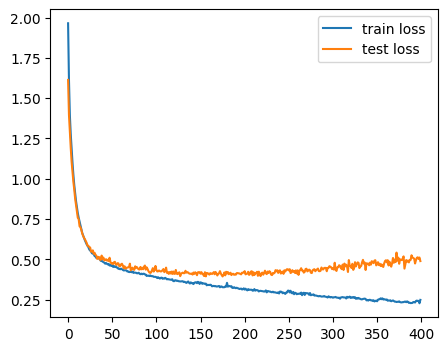

In [15]:
plt.figure(figsize=(5, 4))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [16]:
predictions_train = []
predictions_test =  []
with torch.no_grad():
    predictions_train = model(X_train).to(device)
    predictions_test = model(X_test).to(device)

In [17]:
def get_accuracy_multiclass(pred_arr,original_arr):
    if len(pred_arr) != len(original_arr):
        return False
    pred_arr = pred_arr.cpu().numpy()
    original_arr = original_arr.cpu().numpy()
    final_pred = []
    for i in range(len(pred_arr)):
        final_pred.append(np.argmax(pred_arr[i]))
    final_pred = np.array(final_pred)
    count = 0
    for i in range(len(original_arr)):
        if final_pred[i] == original_arr[i]:
            count+=1
    return count/len(final_pred)

In [18]:
train_acc = get_accuracy_multiclass(predictions_train, y_train)
test_acc  = get_accuracy_multiclass(predictions_test, y_test)

print(f"Training Accuracy: {round(train_acc*100,3)}")
print(f"Test Accuracy: {round(test_acc*100,3)}")

Training Accuracy: 92.019
Test Accuracy: 87.476


# testdata

In [19]:
df_test = df_test_1.copy()

In [20]:
def transform_test():
    global df_test
    for col in binary_cols:
        df_test[col] = df_test[col].map({'yes': 1, 'no': 0})
    df_test['CAEC'] = df_test['CAEC'].map({
    'no': 0,
    'Always': 3,
    'Frequently': 2,
    'Sometimes': 1
})

    df_test['CALC'] = df_test['CALC'].map({
        'no': 0,
        'Frequently': 2,
        'Sometimes': 1,
        'Always': 3
})
    df_test = pd.get_dummies(df_test, columns=['Gender'], prefix='Is', dtype='int64')
    df_test.drop(columns=['Is_Male'], inplace=True)
    df_test['MTRANS'] = df_test['MTRANS'].map(transport_mapping)
    df_test['BMI'] = df_test['Weight'] / (df_test['Height'] ** 2)

In [21]:
transform_test()

# model

In [22]:
test_features = df_test.drop(['id'], axis=1).values
test_features = torch.FloatTensor(test_features).to(device)

In [23]:
predictions_final = model(test_features).to(device)

In [24]:
predicted_classes = torch.argmax(predictions_final, dim=1).cpu()

# Id＋target 

In [25]:
final_output = pd.concat([pd.DataFrame(df_test['id']), pd.DataFrame(predicted_classes)], axis=1)
final_output.rename(columns={0: 'NObeyesdad'}, inplace=True)

final_output.head()

,id,NObeyesdad
0,20758,5
1,20759,2
2,20760,6
3,20761,4
4,20762,6


In [26]:
target_mapping_rev = {target_mapping[k] : k for k in target_mapping}
target_mapping_rev

{0: 'Insufficient_Weight',
 1: 'Normal_Weight',
 2: 'Overweight_Level_I',
 3: 'Overweight_Level_II',
 4: 'Obesity_Type_I',
 5: 'Obesity_Type_II',
 6: 'Obesity_Type_III'}

In [27]:
final_output['NObeyesdad'] = final_output['NObeyesdad'].map(target_mapping_rev)

In [28]:
final_output

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


# submit

In [29]:
final_output.to_csv('submission.csv', index=False)